Author: A.Radhakrishnan, GFDL


In [1]:
import xarray as xr
import intake
import intake_esm
import sys
#from dask_gateway import Gateway
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.options.display.max_rows = None
import matplotlib.pyplot as plt


ACCESS DATA FROM INTAKE CATALOG
Variables needed: Omon/tos and Ofx/areacello

esgf-world.json is the ESM collections spec file for the netCDF data in the S3 bucket esgf-world. 
The catalog is updated on an on-demand basis for now. 
You can refer to https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/esm-collection-spec-examples for the most recent catalogs
More examples can be found in https://github.com/aradhakrishnanGFDL/gfdl-aws-analysis/tree/community/examples 


In [2]:
#col_url = "https://cmip6-nc.s3.us-east-2.amazonaws.com/esgf-world.json" 
col_url = "https://raw.githubusercontent.com/aradhakrishnanGFDL/gfdl-aws-analysis/master/esm-collection-spec-examples/esgf-world.json"

In [3]:
col = intake.open_esm_datastore(col_url)
esmcol_data = col.esmcol_data 

In [4]:
def latest_version(cat):
    """
    input
    cat: esmdatastore
    output
    esmdatastore with latest DRS versions
    """
    latest_cat = cat.df.sort_values(by=['version','path']).drop_duplicates(['temporal_subset','source_id','table_id',
                                               'institution_id','variable_id','member_id',
                                               'grid_label','experiment_id'],keep='last')
    return latest_cat

In [5]:
query_Omon = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Omon'],
                 member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=['GFDL-ESM4'],
                 grid_label=['gn'],
                 variable_id=["tos"])

In [6]:
cat_Omon = col.search(**query_Omon)
cat_Omon_lat = latest_version(cat_Omon)
cat_Omon_lat = intake.open_esm_datastore(cat_Omon_lat,esmcol_data=esmcol_data)

In [ ]:
dset_dict_Omon = cat_Omon_lat.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {'time': 1}})

In [ ]:
query_Ofx = dict(experiment_id=['abrupt-4xCO2','1pctCO2','historical'],
                 table_id=['Ofx'],
               #  member_id=["r1i1p1f1","r1i1p1f2"],
                 source_id=['GFDL-ESM4'],
                 grid_label=['gn'],
                 variable_id=["areacello"])

cat_Ofx = col.search(**query_Ofx)
cat_Ofx_lat = latest_version(cat_Ofx) 
cat_Ofx_lat = intake.open_esm_datastore(cat_Ofx_lat,esmcol_data=esmcol_data)
dset_dict_Ofx = cat_Ofx_lat.to_dataset_dict(storage_options=dict(anon=True),cdf_kwargs={'decode_times': True,'chunks': {}})

In [9]:
ds = dset_dict_Omon["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Omon"] #xarray dataset object to access Omon tos dataset

In [10]:
ds2 = dset_dict_Ofx["CMIP6.NOAA-GFDL.GFDL-ESM4.historical.Ofx"] #xarray dataset object to access Ofx areacello dataset used to calculate the weighted average

NINO3 INDEX CALCULATION 

REGION 

(5S-5N , 150W-90W) 

SELECT tos and areacello for the region of interest

In [11]:
#TODO INSERT CORRECT CODE TO SELECT SPECIFIED REGION (lat range and lon range) in TOS 
#tos = ds.tos......

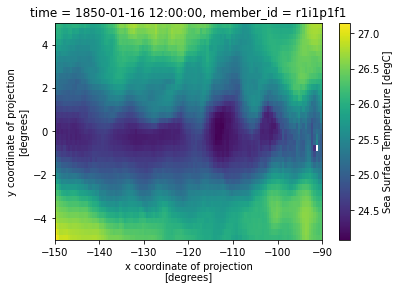

In [51]:
tos.isel(time=0).plot()

In [12]:
#TODO INSERT CELL SELECT region of interest in areacello
#areacello_nino34 = ds2.areacello...

In [ ]:
#TODO 
CALCULATE total_areacello, summation across lat,lon (in our dataset y,x respectively)

total_areacello = areacello_nino34.<insert-function>(dim=('x', 'y'))


CALCULATE SEA SURFACE TEMPERATURE WEIGHTED AVERAGE

In [14]:
tos_mean_nino3 = (tos * areacello_nino34).sum(dim=('x', 'y')) / total_areacello
#nino3_index.plot()

In [ ]:
tos_mean_nino3.compute()

In [29]:
tos_mean_nino3.size #1980 values, 1 value per month , 12 per year for 165 years

1980

In [ ]:
tos_mean_nino3.isel(time=0).compute()

In [ ]:
datetimeindex = tos_mean_nino3.indexes['time'].to_datetimeindex()
tos_mean_nino3['time'] = datetimeindex


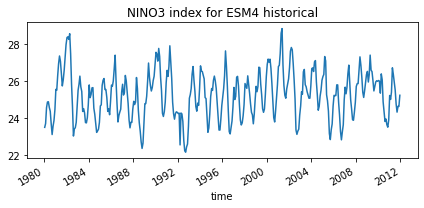

In [49]:
tos_mean_nino3.sel(time=slice('1980','2011')).plot(aspect=2, size=3)
plt.title("NINO3 index for ESM4 historical")
plt.tight_layout()
plt.draw()

ADDITIONAL exploration

CLIMATOLOGY (average all Jans, Febs, etc) CALC EXAMPLES (YEARS NEED A TWEAK, calculate for 20 year chunks or as needed)

In [67]:
tos_nino3_climatology = tos.sel(time=slice('1950','1951')).groupby('time.month').mean(dim='time')


In [ ]:
tos_nino3_climatology.compute()

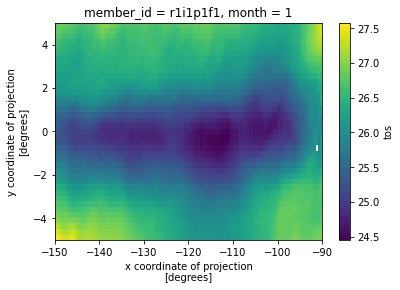

In [79]:
tos_nino3_climatology.isel(month=0).plot()

monthly anomaly of SST (or TOS here) over the Nino3 region

we subtract the monthly climatology values calculated above from the TOS value values and then do
a spatial average across the region of interest

In [60]:
tos_sel = tos.sel(time=slice('1950','1951'))
index_nino3 = (tos_sel.groupby('time.month')-tos_nino3_climatology).mean(dim=['x','y'])

In [ ]:
index_nino3.compute()

<ipython-input-64-90fd70a17ab6>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = index_nino3.indexes['time'].to_datetimeindex()


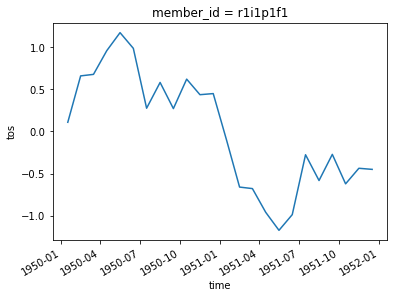

In [64]:
datetimeindex = index_nino3.indexes['time'].to_datetimeindex()
index_nino3['time'] = datetimeindex
index_nino3.plot()